In [1]:
%matplotlib inline

# Operating Borealis -- beginner tutorial

*Authors: Fabian Laudenbach and Theodor Isacsson*

<div class="alert alert-info"><h4>Note</h4> <p>For users in a hurry, check out the <a href="./Borealis_quickstart.ipynb">Borealis quickstart tutorial</p></a>.</div>

The demonstration of quantum-computational advantage (i.e., the ability of a
quantum processor to accomplish a task exponentially faster than any super
computer could) is considered an important milestone towards useful quantum
computers. One task that is proven to be computationally hard is sampling the
photon numbers of multimode squeezed states that have travelled through a
non-trivial interferometer --- a problem which is referred to as Gaussian Boson
Sampling (GBS). In [1], Xanadu showcases a
programmable loop interferometer that can successfully sample GBS instances orders
of magnitudes faster than any known classical algorithm could using exact methods. The experiment is
based on temporal-division multiplexing (TDM) --- also known as time-domain
multiplexing --- which allows for a comparatively simple experimental setup in
which the number of optical parts and devices is independent from the number of
optical modes. A single squeezed-light source emits batches of 216 time-ordered
squeezed-light pulses. These pulses interfere with one another with the help
of optical delay loops (acting as memory buffers), programmable beamsplitters,
and phase shifters. A simple schematic of the setup can be seen below.

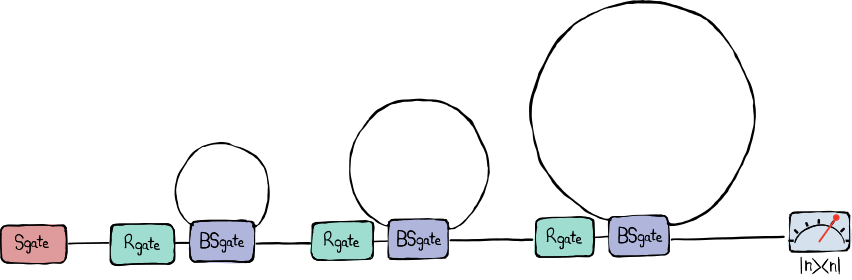

The architecture of Xanadu's GBS machine, Borealis, is layed out
as follows. A squeezed-light source injects pulse trains of 216 modes,
temporally spaced by $\tau = 167~\text{ns}$, into the interferometer which
consists of three delay loops that are individually characterized by the
roundtrip time it takes a mode to travel trough it. The first, second,
and third delay loops have a roundtrip time of $1 \tau$, $6 \tau$,
and $36 \tau$, respectively. Each loop is associated with two programmable
Gaussian gates; a rotation gate right before the loop and a variable
beamsplitter that interferes modes approaching the loop with modes coming from
*within* the loop.

In this tutorial, we will discuss how a GBS circuit on Borealis can be
programmed using the `strawberryfields.TDMProgram` class. This class allows us
to define and run time-multiplexed photonic circuits in a very efficient way,
even if these circuits include large numbers of modes. For more background on
the `TDMProgram`, please refer to the <a href="./3_Time_domain_photonic_circuits.ipynb">beginner tutorial</a> on time-domain photonic circuits, and the
[advanced tutorial](https://strawberryfields.ai/photonics/demos/run_advanced_time_domain.html) on the Strawberry Fields website.

After defining our GBS circuit, we can either submit the program to the
hardware, run a simulation or do both.


## Loading the device specification

To start off, we import Strawberry Fields along with NumPy, which we will need
later on. We then need to load the device object which contains relevant
and up-to-date information about Borealis. It includes two dictionaries: the
device specification (Borealis uptime, allowed circuit layout, allowed gate
parameters) and the device certificate (most recent calibration results).

The following code creates a ``BraketEngine`` to access Borealis via Amazon
Braket. We can then retrieve the device from the platform upon
connecting to Borealis by calling the ``eng.device`` property on the
``BraketEngine`` object. For more details, see the documentation for the [Amazon Braket Strawberry Fields plugin](https://amazon-braket-strawberryfields-plugin-python.readthedocs.io/).



In [2]:
import strawberryfields as sf
import numpy as np
from braket.strawberryfields_plugin import BraketEngine

eng = BraketEngine("arn:aws:braket:us-east-1::device/qpu/xanadu/Borealis")
device = eng.device

The ``device`` allows us to make your TDM circuit compatible with the hardware.
This is why it is passed to some of the functions defined below. In
particular, these functions need to access the latest calibration results
which you can view yourself in the device certificate.



In [3]:
device.certificate

{'finished_at': '2022-05-13T12:31:34.430968+00:00',
 'target': 'borealis',
 'loop_phases': [0.06293596790273215,
  0.15291642690139806,
  -1.5957742826142312],
 'schmidt_number': 1.1240597475954237,
 'common_efficiency': 0.42871142768980564,
 'squeezing_parameters': {'low': [0.6130577606615072],
  'high': [1.0635796125448667],
  'medium': [0.893051739389763]},
 'squeezing_parameters_mean': {'low': 0.6130577606615072,
  'high': 1.0635796125448667,
  'medium': 0.893051739389763},
 'relative_channel_efficiencies': [0.9305010775397536,
  0.9648681625753431,
  0.9518909571324008,
  0.9486638084844965,
  0.8987246282353925,
  0.9726334999710303,
  0.9489037154275138,
  0.9727238556532112,
  1.0,
  0.973400900408643,
  0.8771940466934924,
  0.9271209514090495,
  0.9595068270114586,
  0.9002874120338067,
  0.911213274548878,
  0.9752842185805198]}

## Defining a GBS circuit

A time-domain program is defined by the sequences of arguments each quantum
gate applies at each time bin, i.e., on each temporal mode, within the duration of the program. As
Borealis is an interferometer with a total of seven Gaussian gates (one
squeezer, three rotation gates, and three tunable beamsplitters), we require seven
lists of arguments:

- ``r``: sequence of squeezing values
-  ``phi_0``, ``phi_1``, ``phi_2``: sequences of arguments applied by the
   rotation gates
-  ``alpha_0``, ``alpha_1``, ``alpha_2``: sequences of arguments applied by
   the beamsplitters

### Fast track

If you do not want to be bothered with defining the gate arguments yourself and just want to run
and analyze *some* GBS instance, simply call the `borealis_gbs` helper function and proceed to
the <a href="#executing-the-circuit">Executing the Circuit</a> section below. The ``gate_args_list`` summarizes all the
necessary information for Strawberry Fields and our hardware to implement your circuit. In
particular, it contains the arguments to be applied by our seven Gaussian gates at each time bin.
Your circuit will be roughly equivalent to the ones presented in the publication
[1]. All you need to do is to specify the number of modes (up to 288) and a
squeezing level (``"low"``, "``medium``", or "``high``").

We also need to import two other helper functions, which will be explained and used later.



In [4]:
from strawberryfields.tdm import borealis_gbs, full_compile, get_mode_indices

gate_args_list = borealis_gbs(device, modes=216, squeezing="high")

2022-05-27 16:14:11,324 - WARNING - 152/259 arguments of phase gate 1 have been shifted by pi in order to be compatible with the phase modulators.
2022-05-27 16:14:11,325 - WARNING - 135/259 arguments of phase gate 2 have been shifted by pi in order to be compatible with the phase modulators.


### Define your gates manually (optional)

If you want to be more in control of what your circuit should look like, we invite you to follow
through with the following couple of steps. Let's begin by defining the squeezing values, for
instance, by creating a list with the same number of parameters as the number of modes in the
program.


In [5]:
modes = 216

# squeezing-gate parameters
r = [1.234] * modes

The squeezing values you define will later be matched to the closest one
supported by the hardware. You can always view the supported values by calling
``device.certificate["squeezing_parameters_mean"]``. In case you are unsure
about what squeezing value to apply, we also support string values instead of
numeric lists. You can set ``r`` to ``"zero"``, ``"low"``, ``"medium"``, or
``"high"`` to access one of the pre-calibrated squeezing levels which will
then be applied to all pulses in your program.

For our GBS job, we draw the phase-gate arguments and beamsplitter transmission
values from a uniform random distribution. The beamsplitter intensity
transmission can be set anywhere between 0 and 1, but in order to obtain a
denser adjacency matrix (i.e. a better spread of entanglement throughout the
modes) we limit the range to $T \in [0.4, 0.6]$. Given some intensity
transmission $T$, the argument passed to our beamsplitter will then be
$\alpha=\text{arccos}(\sqrt{T})$. Considering this conversion, we can
define our random sequences.




In [6]:
min_phi, max_phi = 0, 2 * np.pi
min_T, max_T = 0.4, 0.6

# rotation-gate parameters
phi_0 = np.random.uniform(low=min_phi, high=max_phi, size=modes)
phi_1 = np.random.uniform(low=min_phi, high=max_phi, size=modes)
phi_2 = np.random.uniform(low=min_phi, high=max_phi, size=modes)

# beamsplitter parameters
T_0 = np.random.uniform(low=min_T, high=max_T, size=modes)
T_1 = np.random.uniform(low=min_T, high=max_T, size=modes)
T_2 = np.random.uniform(low=min_T, high=max_T, size=modes)
alpha_0 = np.arccos(np.sqrt(T_0))
alpha_1 = np.arccos(np.sqrt(T_1))
alpha_2 = np.arccos(np.sqrt(T_2))

Now, we want to set the first arguments of each loop to $T=1$
($\alpha=0$). This will couple an incoming pulse entirely into the loop,
and a vacuum mode that was inside the loop will be coupled out — no
interference between the two will occur. For each loop this needs to be
repeated until the respective delay line is completely emptied from vacuum
modes and filled with computational modes (i.e. optical pulses).




In [7]:
# the travel time per delay line in time bins
delay_0, delay_1, delay_2 = 1, 6, 36

# set the first beamsplitter arguments to 'T=1' ('alpha=0') to fill the
# loops with pulses
alpha_0[:delay_0] = 0.0
alpha_1[:delay_1] = 0.0
alpha_2[:delay_2] = 0.0

For convenience, let's collect the gate arguments in a dictionary. This can
also be done with the helper function `to_args_dict`, but we
will show the dictionary creation manually for clarity.



In [8]:
gate_args = {
    "Sgate": r,
    "loops": {
        0: {"Rgate": phi_0.tolist(), "BSgate": alpha_0.tolist()},
        1: {"Rgate": phi_1.tolist(), "BSgate": alpha_1.tolist()},
        2: {"Rgate": phi_2.tolist(), "BSgate": alpha_2.tolist()},
    },
}

Before we can submit these gates to Strawberry Fields, we need to make some
adjustments to the lists in order to account for the peculiarities of the
hardware and TDM circuits in general:

- **Squeezing level**: Only a discrete set of squeezing parameters is properly
  calibrated. These are the values that the hardware is able to apply. The
  squeezing values in your ``r`` list need to be matched to the closest value
  that is supported by the hardware.
- **Mode delay**: Note that the gate sequences you have defined for the respective
  loops do not necessarily start at the same time. It all depends on how long
  the arrival of the first pulse at a respective loop (and its rotation and
  beamsplitter gate) has been delayed by previous loops. Therefore, the time
  that each gate sequence starts has to be delayed accordingly.
- **Emptying the delay loops**: When your time-domain circuit is over, there might
  still be some pulses travelling in the fibre loops. The variable
  beamsplitters must be set such that these modes can exit the loops and
  travel to the detector module.
- **Phase corrections**: On top of applying the phase-gate arguments that you ask
  for, the phase modulators need to compensate for other, static, non-programmable
  phase offsets in the setup. In some cases, the offset-corrected phase falls
  beyond range of the modulators. So we want to make sure that all the
  phase-gate arguments submitted to the `TDMProgram` can actually be
  implemented in the presence of the non-programmable phase offsets.

These compilation steps can be carried out individually (manually, or by
calling the respective Strawberry Fields helper functions) as described in the
advanced tutorial. However, we can
conveniently call the `full_compile` function which takes care of
all these steps at once.




In [9]:
gate_args_list = full_compile(gate_args, device)

2022-05-06 11:11:32,037 - WARNING - Submitted squeezing values have been matched to the closest median value supported by hardware: ['0.000', '0.673', '0.963', '1.158'].
2022-05-06 11:11:32,038 - WARNING - 118/259 arguments of phase gate 1 have been shifted by pi in order to be compatible with the phase modulators.
2022-05-06 11:11:32,038 - WARNING - 130/259 arguments of phase gate 2 have been shifted by pi in order to be compatible with the phase modulators.


<div class="alert alert-info"><h4>Note</h4><p>As mentioned above, we sometimes need to delay the beginning of the gate
   sequences depending on the delay applied by previous loop(s) at the arrival
   of the first pulse so that they can start right on time. Also, we want a program
   to end with open loops in order to give all modes the opportunity to exit
   the delay lines and travel to the detectors. Both of these goals are achieved
   by adding particular amounts of zeros to the beginning and end of the
    respective gate lists. This is why after calling <tt>full_compile()</tt>, your
   gate lists have grown, which you can easily verify yourself.</p></div>





Executing the circuit<a id='executing-the-circuit'></a>
---------------------

In order to execute a circuit we need to submit it to a Strawberry Fields
`TDMProgram`. Our first step will be to declare the delays in the loops,
i.e. the number of modes that will fit in each loop at the same time. We can
then use a helper function called `get_mode_indices` to get the number of
modes that are alive at the same time (*concurrent* modes) ``N``, which is required
for initializing the `TDMProgram`, and the correct mode indices ``n`` for the
circuit gates. The parameter ``n`` helps us to define the `TDMProgram` in a
really concise way, as you will see below.



In [10]:
delays = [1, 6, 36]
vac_modes = sum(delays)

n, N = get_mode_indices(delays)

Finally, we can construct the circuit. The layout of this circuit is
set by the hardware device and cannot be changed. If the wrong gates are
used or they are put in the wrong order, the circuit validation will
fail.




In [11]:
from strawberryfields.ops import Sgate, Rgate, BSgate, MeasureFock

prog = sf.TDMProgram(N)

with prog.context(*gate_args_list) as (p, q):
    Sgate(p[0]) | q[n[0]]
    for i in range(len(delays)):
        Rgate(p[2 * i + 1]) | q[n[i]]
        BSgate(p[2 * i + 2], np.pi / 2) | (q[n[i + 1]], q[n[i]])
    MeasureFock() | q[0]

### Submit to hardware and analyze results

After constructing the circuit, now uniquely defined by the ``prog``
object, we can submit it to Borealis by calling and running the
``BraketEngine`` object that we created above.




<div class="alert alert-block alert-warning">
<b>Caution:</b> The following code will result in <a href="https://aws.amazon.com/braket/pricing/">usage fees</a> for Borealis. Please only uncomment the cell if you are comfortable with the costs; otherwise continue onto the <a href="#submit-local-simulation">local simulation</a> section.</div>

In [12]:
# shots = 250_000
# results = eng.run(prog, shots=shots, crop=True)

# samples = results.samples

<div class="alert alert-info"><h4>Note</h4><p>Depending on how long the first optical pulse is delayed by the respective
     loops, the circuit will measure a couple of empty modes at the beginning. The
    <tt>crop=True</tt> flag will make sure these empty modes are not returned.</p></div>




Running the circuit remotely on Borealis will return a `Result` object which contains the samples that are obtained
by the machine. The samples returned by any `TDMProgram` are of shape ``(shots, spatial modes, temporal modes)``. So, in our case we should have received samples of shape ``(shots, 1, 216)``.

If you followed through with the above steps, you have just run a GBS
instance of the same type as demonstrated in Xanadu's manuscript
[1]! This paper also explains how to obtain the estimated
runtime required by *Fugaku* (currently the world's most powerful classical
supercomputer) to simulate the individual GBS samples. You can compute these
runtimes for the GBS samples that you just created using the Strawberry Fields
utility function `gbs_sample_runtime`. Note, however, that this
analysis is based on the *current* *Fugaku* specs (characterized by the
LINPACK supercomputer benchmarks) and on the best *known* algorithm to compute
Hafnians. Therefore, this estimation of simulation runtime can be affected in
the future by the advent of more powerful computers and/or more efficient
algorithms.



In [13]:
from strawberryfields.utils import gbs_sample_runtime

runtimes = np.array([gbs_sample_runtime(sample[0]) for sample in samples])

Let us illustrate the simulation runtimes in a histogram using ``matplotlib.pyplot``.



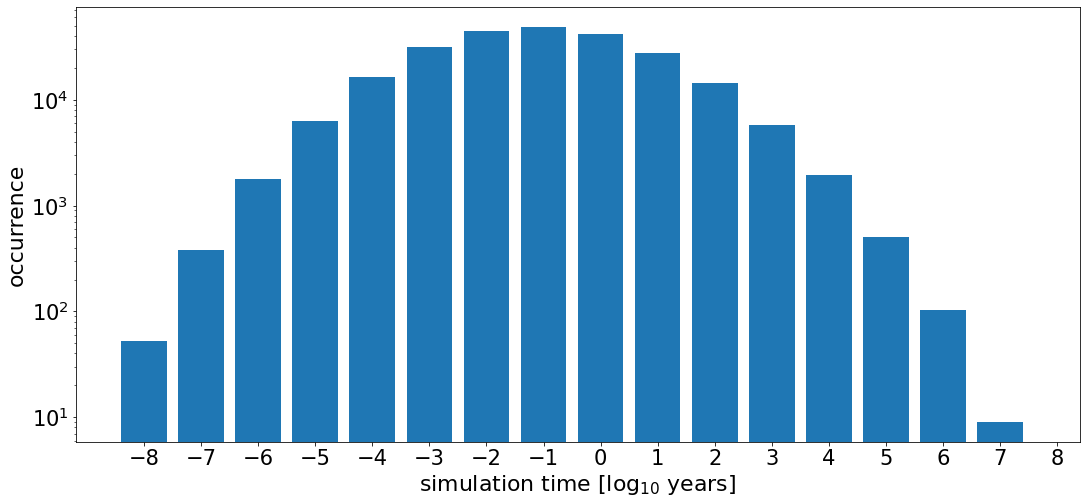

In [14]:
import matplotlib.pyplot as plt

fs_axlabel = 22
fs_text = 20
fs_ticklabel = 21
fs_legend = 20

def plot_simulation_time(runtimes):
    """Plots a histogram with simulation times.

    Args:
        runtimes (array[float]): the runtimes per GBS sample
    """
    runtimes_log_years = np.log10(runtimes / 365 / 24 / 3600)
    max_exponent = int(max(runtimes_log_years))
    min_exponent = int(min(runtimes_log_years))

    _, ax = plt.subplots(figsize=(18, 8))
    bins = np.arange(min_exponent, max_exponent + 1)
    ax.hist(runtimes_log_years, width=0.8, bins=bins - 0.4)
    ax.set_xlabel(r"simulation time [log$_{10}$ years]", fontsize=fs_axlabel)
    ax.set_ylabel("occurrence", fontsize=fs_axlabel)
    ax.set_yscale("log")
    ax.tick_params(axis="x", labelsize=fs_ticklabel)
    ax.tick_params(axis="y", labelsize=fs_ticklabel)
    ax.set_xticks(bins)

    plt.show()

plot_simulation_time(runtimes)

We can also print the median and average simulation time per sample, the simulation time of your
brightest sample (the one with the most photons in it), and the time it would take to simulate
*all* the samples you created.



In [15]:
runtime_data = f"""
simulation runtimes [years]
median: {np.median(runtimes) / 365 / 24 / 3600:.1E}
average: {np.mean(runtimes) / 365 / 24 / 3600:.1E}
brightest: {np.max(runtimes) / 365 / 24 / 3600:.1E}
total: {np.sum(runtimes) / 365 / 24 / 3600:.1E}
"""

print(runtime_data)


simulation runtimes [years]
median: 1.0E-01
average: 3.0E+03
brightest: 1.6E+08
total: 7.2E+08



Next, let us look at the statistical moments of our samples. The following two
functions will return an array of mean photon numbers for the 216 modes and a
$216 \times 216$ photon-number covariance matrix whose elements are
defined by $\text{Cov}(n_{i}, n_{j}) = E(n_{i} n_{j})
- E(n_{i}) E(n_{j})$.




In [16]:
mean_n = np.mean(samples, axis=(0, 1))
cov_n = np.cov(samples[:, 0, :].T)

Let's visualize these two results in a figure. This figure can then be used to
compare the hardware outcome with local simulations.




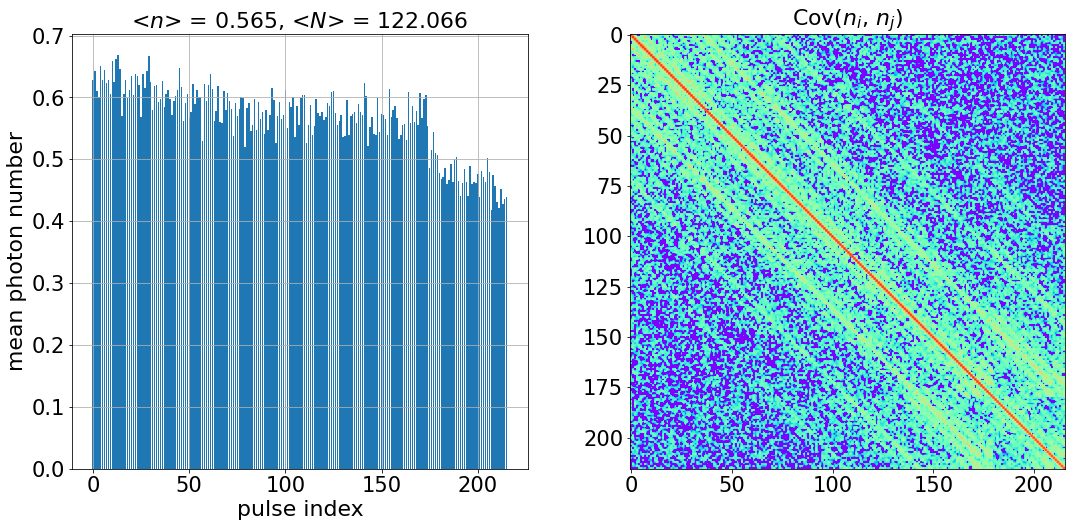

In [17]:
import matplotlib.colors


def plot_photon_number_moments(mean_n, cov_n):
    """Plots first and second moment of the photon-number distribution.

    Args:
        mean_n (array[float]): mean photon number per mode
        cov_n (array[int]): photon-number covariance matrix
    """
    _, ax = plt.subplots(1, 2, figsize=(18, 8))

    ax[0].bar(range(len(mean_n)), mean_n, width=0.75, align="center")
    ax[0].set_title(
        rf"<$n$> = {np.mean(mean_n):.3f}, <$N$> = {np.sum(mean_n):.3f}",
        fontsize=fs_axlabel,
    )
    ax[0].set_xlabel("pulse index", fontsize=fs_axlabel)
    ax[0].set_ylabel("mean photon number", fontsize=fs_axlabel)
    ax[0].grid()
    ax[0].tick_params(axis="x", labelsize=fs_ticklabel)
    ax[0].tick_params(axis="y", labelsize=fs_ticklabel)

    ax[1].imshow(
        cov_n,
        norm=matplotlib.colors.SymLogNorm(
            linthresh=10e-6, linscale=1e-4, vmin=0, vmax=2
        ),
        cmap="rainbow",
    )
    ax[1].set_title(r"Cov($n{_i}$, $n{_j}$)", fontsize=fs_axlabel)
    ax[1].tick_params(axis="x", labelsize=fs_ticklabel)
    ax[1].tick_params(axis="y", labelsize=fs_ticklabel)

    plt.show()


plot_photon_number_moments(mean_n, cov_n)

### Submit to local simulation and compare to hardware results<a id='submit-local-simulation'></a>

Now, let us switch to a local simulation and see how the results compare
against the experimental data. By design, Borealis is an experiment that is
difficult to sample from classically. What the simulator devices *cannot* do
is return actual samples the same way the Borealis device does, at least not in
a reasonable amount of time. Setting ``shots=None`` in the `Engine.run` call
below makes sure that the local engine doesn't even attempt to simulate GBS
outcomes. Still, even though the engine won't return samples, running the
circuit locally on the Gaussian backend returns a `Result` object with
many other interesting properties.

Loss channels will be added to the program to make
the simulation more realistic. To do this, the actual efficiency
values obtained in the most recent Borealis calibration run, which are
stored in the device certificate, will be used during the compilation process.



We begin by collecting the options that we wish to pass to the compiler prior to running the
simulation. To apply realistic loss, instead of using the default backend compiler we need to
compile the program using the Borealis compiler. We also need to pass the device along to the
engine since it's required by the Borealis compiler and also contains the relevant efficiency
values used when applying the loss.



In [18]:
compile_options = {
    "device": device,
    "realistic_loss": True,
}

Finally, we can run the program on the Gaussian backend, setting the number of shots to ``None``
--- meaning that no sampling will be attempted --- and the ``crop`` keyword to ``True``, cropping
away the empty modes at the beginning. We also need to tell the engine to
space-unroll the circuit before running it. Otherwise, the simulation will
only handle the concurrent modes, i.e. the modes that are simultaneously alive
at a given time (in our case 44), causing the final state to only contain a
subset of all the modes. You can read more about space-unrolling in the [advanced tutorial](https://strawberryfields.ai/photonics/demos/run_advanced_time_domain.html) for time-domain multiplexing.

To make the code a bit cleaner, we collect all run options in a dictionary which we can unwrap in
the run call signature.



In [19]:
run_options = {
    "shots": None,
    "crop": True,
    "space_unroll": True,
}

eng_sim = sf.Engine(backend="gaussian")
results_sim = eng_sim.run(prog, **run_options, compile_options=compile_options)

When executing the program on a simulator device, we can extract the covariance
matrix by calling the `cov()` method on the returned state, which is not
possible when running on Borealis.



In [20]:
cov = results_sim.state.cov()

The covariance matrix describes the quadrature relations of the individual
modes and, in the absence of displacements, contains the full information of
the Gaussian state. However, if we want to be able to compare the simulation
against experimental data, we would like to obtain the same photon-number
statistics as above: the array of mean photon numbers for the 216 modes and a
$216 \times 216$ photon-number covariance matrix. We can use
``photon_number_mean_vector()`` and ``photon_number_covmat()``, two functions
from Xanadu's open-source library The Walrus to obtain these distributions from the quadrature covariance matrix.




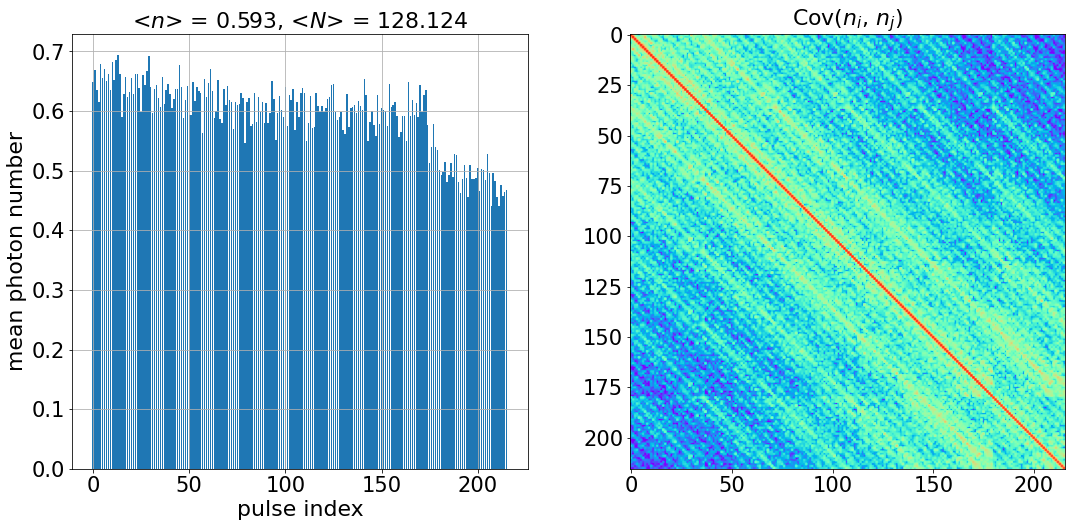

In [21]:
from thewalrus.quantum import (
    photon_number_mean_vector,
    photon_number_covmat,
)

mu = np.zeros(len(cov))
mean_n_sim = photon_number_mean_vector(mu, cov)
cov_n_sim = photon_number_covmat(mu, cov)

plot_photon_number_moments(mean_n_sim, cov_n_sim)

If you have submitted the same circuit to both Borealis and the local simulator backend,
following the steps above, you should be able to compare the two results. We can also visualize
the similarities between the two using scatter plots with the first and second moments of the
simulated and experimental photon-number distributions.



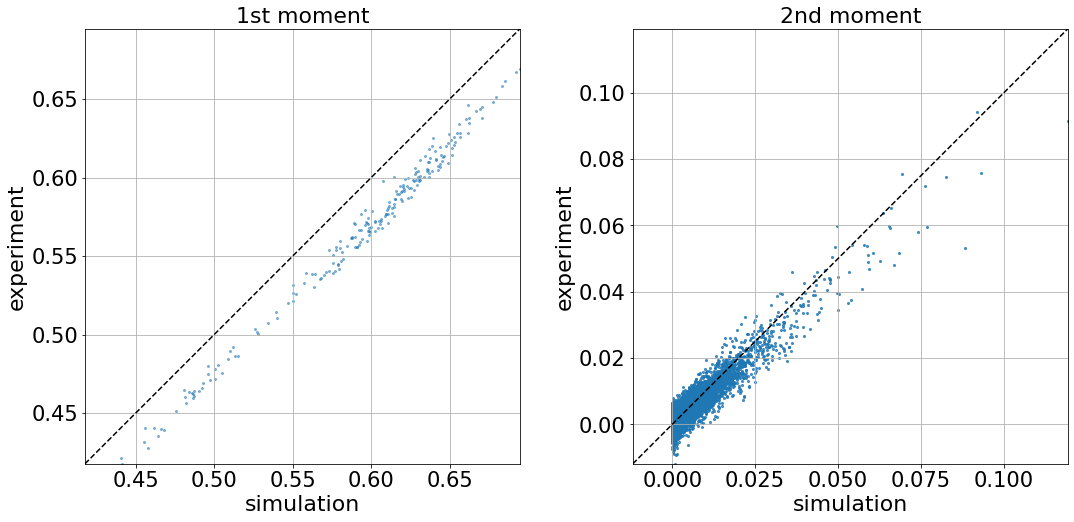

In [22]:
def plot_photon_number_moment_comparison(mean_n_exp, mean_n_sim, cov_n_exp, cov_n_sim):
    """Plot first and second moment of the PNR distribution.

    Compare in scatter plots the first and second moments of the photon-number
    distribution resulting from experiment and simulation.

    Args:
        mean_n_exp (array): experimental mean photon number per mode
        mean_n_sim (array): simulated mean photon number per mode
        cov_n_exp (array): experimental photon-number covariance matrix
        cov_n_sim (array): simulated photon-number covariance matrix
    """
    cov_n_exp2 = np.copy(cov_n_exp)
    cov_n_sim2 = np.copy(cov_n_sim)

    # remove the diagonal elements (corresponding to the single-mode variance)
    # which would otherwise be dominant
    cov_n_exp2 -= np.diag(np.diag(cov_n_exp2))
    cov_n_sim2 -= np.diag(np.diag(cov_n_sim2))

    _, ax = plt.subplots(1, 2, figsize=(18, 8))

    min_ = np.min([mean_n_sim, mean_n_exp])
    max_ = np.max([mean_n_sim, mean_n_exp])
    ax[0].scatter(mean_n_sim, mean_n_exp, s=4, alpha=0.50)
    ax[0].plot([min_, max_], [min_, max_], "k--")
    ax[0].set_title("1st moment", fontsize=fs_axlabel)
    ax[0].set_xlabel("simulation", fontsize=fs_axlabel)
    ax[0].set_ylabel("experiment", fontsize=fs_axlabel)
    ax[0].set_xlim([min_, max_])
    ax[0].set_ylim([min_, max_])
    ax[0].set_aspect("equal", adjustable="box")
    ax[0].tick_params(axis="x", labelsize=fs_ticklabel)
    ax[0].tick_params(axis="y", labelsize=fs_ticklabel)
    ax[0].grid()

    min_ = np.min([cov_n_sim2, cov_n_exp2])
    max_ = np.max([cov_n_sim2, cov_n_exp2])
    ax[1].scatter(cov_n_sim2, cov_n_exp2, s=4, alpha=0.50)
    ax[1].plot([min_, max_], [min_, max_], "k--")
    ax[1].set_title("2nd moment", fontsize=fs_axlabel)
    ax[1].set_xlabel("simulation", fontsize=fs_axlabel)
    ax[1].set_ylabel("experiment", fontsize=fs_axlabel)
    ax[1].set_xlim([min_, max_])
    ax[1].set_ylim([min_, max_])
    ax[1].set_aspect("equal", adjustable="box")
    ax[1].tick_params(axis="x", labelsize=fs_ticklabel)
    ax[1].tick_params(axis="y", labelsize=fs_ticklabel)
    ax[1].grid()

    plt.show()


plot_photon_number_moment_comparison(mean_n, mean_n_sim, cov_n, cov_n_sim)

Conclusion
----------

This tutorial covered how to submit jobs to Xanadu's temporal-division multiplexing
device Borealis. It's rather exciting to be able to demonstrate the concept
of quantum-computational advantage by examples running on actual hardware. As
you have now seen, there are quite a few details to keep track of. As
long as the circuit follows the correct layout and the parameters are
correctly declared, anyone with an AWS account can submit tasks to be
executed on Borealis and get back samples that would be difficult, if not
outright impossible, to retrieve using a local simulator.

You can find some more examples of how to visualize your data [here](https://github.com/XanaduAI/strawberryfields/blob/master/examples/gbs_data_visualization.py).

We hope that you've enjoyed this demonstration and that you're as excited as
we are about the possibilities. If you wish to dig deeper into the science
behind all of this, we recommend that you read Xanadu's paper [1] and check out the [advanced Borealis tutorial](https://strawberryfields.ai/photonics/demos/tutorial_borealis_advanced.html) on the Strawberry Fields website.




References
----------

[1] Madsen, L.S., Laudenbach, F., Askarani, M.F. et al. “Quantum computational advantage with a programmable photonic processor”, [Nature 606, 75-81](https://www.nature.com/articles/s41586-022-04725-x), 2022.


